In [1]:
import numpy as np
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.simulator import (
    SimulationConfig,
    PanelSimulator,
    FactorDGP,
)
from synthlearners.plotting import SynthPlotter

## Basic use with Panel Matrices

In [2]:
config = SimulationConfig(
    N=100,
    T=50,
    T_pre=40,
    n_treated=10,
    selection_mean=1.0,
    treatment_effect=0.5,
    dgp=FactorDGP(K=2, sigma=1, time_fac_lb=-0.1, time_fac_ub=0.1, trend_sigma=0.0001),
)
simulator = PanelSimulator(config)
Y, Y_0, L, treated_units = simulator.simulate()

In [3]:
treated_units

array([89, 32, 13, 80, 85, 28, 82, 45,  9, 64])

In [4]:
from synthlearners.mcnnm import MatrixCompletionEstimator

In [5]:
# Create a mask indicating which entries are observed.
mask = np.ones_like(Y)
missing_periods = config.T-config.T_pre

# For treated units, suppose the outcomes in the last N periods are missing.
mask[treated_units, -missing_periods:] = 0  

In [6]:
mask[treated_units[0]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
estimator = MatrixCompletionEstimator(
    lambda_param=2e-3,
    max_iter=500,
    tol=1e-6,
    verbose=True
)
estimator.fit(Y, mask)
Y_completed = estimator.completed_matrix_

shrink_treshhold: 4.9
singular values: [16.65381304 16.00477896 14.80961648 14.48945987]
s_thresholded: [11.75381304 11.10477896  9.90961648  9.58945987]
Iteration   1, relative change = 4113061563.945351
singular values: [16.65967278 16.06073817 14.84745486 14.53776351]
s_thresholded: [11.75967278 11.16073817  9.94745486  9.63776351]
Iteration   2, relative change = 0.021431
singular values: [16.6634522  16.09799535 14.87519073 14.56690618]
s_thresholded: [11.7634522  11.19799535  9.97519073  9.66690618]
Iteration   3, relative change = 0.011845
singular values: [16.66556458 16.12143842 14.89385598 14.58403654]
s_thresholded: [11.76556458 11.22143842  9.99385598  9.68403654]
Iteration   4, relative change = 0.006759
singular values: [16.66671114 16.13576846 14.90581737 14.59409793]
s_thresholded: [11.76671114 11.23576846 10.00581737  9.69409793]
Iteration   5, relative change = 0.003950
singular values: [16.66733923 16.14440411 14.91327969 14.60005222]
s_thresholded: [11.76733923 11.2

In [8]:
# Counterfactual Values for imputed periods for single treated example
Y_0[treated_units[0], -missing_periods:]

array([-0.76488391, -0.15174888, -0.13119737,  0.30966483,  0.12721515,
        0.81209996,  0.97510635, -1.01615275,  0.85462799, -1.3490142 ])

In [9]:
# Observed Value for imputed periods from single treated example
Y[treated_units[0], -missing_periods:]

array([-0.26488391,  0.34825112,  0.36880263,  0.80966483,  0.62721515,
        1.31209996,  1.47510635, -0.51615275,  1.35462799, -0.8490142 ])

In [10]:
# MC Values for imputed periods for single treated example
Y_completed[treated_units[0], -missing_periods:]

array([ 0.12295758, -0.22432011, -0.322544  ,  0.3633754 ,  0.34699387,
        0.24513517,  0.00243552, -0.36594639,  0.26558588, -0.56419653])

In [11]:
baseline_bias = Y_completed[treated_units[0], -missing_periods:]-Y_0[treated_units[0], -missing_periods:]
print('Baseline Bias of MC value relative to actual counterfactual',np.mean(baseline_bias))

Baseline Bias of MC value relative to actual counterfactual 0.02037592140397776


In [12]:
te = Y[treated_units[0], -missing_periods:]-Y_completed[treated_units[0], -missing_periods:]
print('Estimated Treatment Effect of Observed relative to MC Value',np.mean(te))

Estimated Treatment Effect of Observed relative to MC Value 0.47962407859602224


In [13]:
print('Treatment Effect Bias',np.abs(np.mean(te)-config.treatment_effect))

Treatment Effect Bias 0.02037592140397776


In [14]:
estimator2 = MatrixCompletionEstimator(
    lambda_param=2e-3,
    max_iter=500,
    tol=1e-6,
    verbose=True
)
# Try approach with fixed effects
estimator2.NNM_fit(Y, mask)
Y_completed2 = estimator.completed_matrix_

singular values: [16.22127844 15.95880986 14.45260627 14.30192058]
s_thresholded: [11.32127844 11.05880986  9.55260627  9.40192058]
singular values: [16.25257795 16.017069   14.49649281 14.32402951]
s_thresholded: [11.35257795 11.117069    9.59649281  9.42402951]
singular values: [16.27306163 16.05507868 14.52385635 14.34019788]
s_thresholded: [11.37306163 11.15507868  9.62385635  9.44019788]
singular values: [16.28559525 16.07805452 14.54011513 14.35085965]
s_thresholded: [11.38559525 11.17805452  9.64011513  9.45085965]
singular values: [16.29307951 16.09146482 14.54964527 14.35753792]
s_thresholded: [11.39307951 11.19146482  9.64964527  9.45753792]
singular values: [16.29751466 16.09918341 14.5552318  14.36160942]
s_thresholded: [11.39751466 11.19918341  9.6552318   9.46160942]
singular values: [16.30014155 16.10361016 14.55852646 14.36406092]
s_thresholded: [11.40014155 11.20361016  9.65852646  9.46406092]
singular values: [16.30170118 16.1061522  14.56048625 14.36552692]
s_thresho

In [15]:
# MC Values for imputed periods for single treated example
Y_completed2[treated_units[0], -missing_periods:]

array([ 0.12295758, -0.22432011, -0.322544  ,  0.3633754 ,  0.34699387,
        0.24513517,  0.00243552, -0.36594639,  0.26558588, -0.56419653])

In [16]:
baseline_bias2 = Y_completed2[treated_units[0], -missing_periods:]-Y_0[treated_units[0], -missing_periods:]
print('Baseline Bias of MC value relative to actual counterfactual',np.mean(baseline_bias2))

Baseline Bias of MC value relative to actual counterfactual 0.02037592140397776


In [17]:
te2 = Y[treated_units[0], -missing_periods:]-Y_completed2[treated_units[0], -missing_periods:]
print('Estimated Treatment Effect of Observed relative to MC Value',np.mean(te2))

Estimated Treatment Effect of Observed relative to MC Value 0.47962407859602224


In [18]:
print('Treatment Effect Bias',np.abs(np.mean(te2)-config.treatment_effect))

Treatment Effect Bias 0.02037592140397776


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.utils import prepare_panel

In [20]:
adh_data = pd.read_csv("ADH2015.csv", index_col=0)
adh_data = adh_data[['country', 'year', 'gdp']]
# manually create treatment indicator
adh_data['treat'] = np.where((adh_data.country == "West Germany") & (adh_data.year > 1990), 1, 0)
adh_data.head()

,country,year,gdp,treat
index,,,,
1.0,USA,1960.0,2879,0
1.0,USA,1961.0,2929,0
1.0,USA,1962.0,3103,0
1.0,USA,1963.0,3227,0
1.0,USA,1964.0,3420,0


In [21]:
data = prepare_panel(
    adh_data,
    unit_col="country",
    time_col="year",
    outcome_col="gdp",
    treatment_col="treat",
)

Text(0.5, 1.0, 'Treatment matrix')

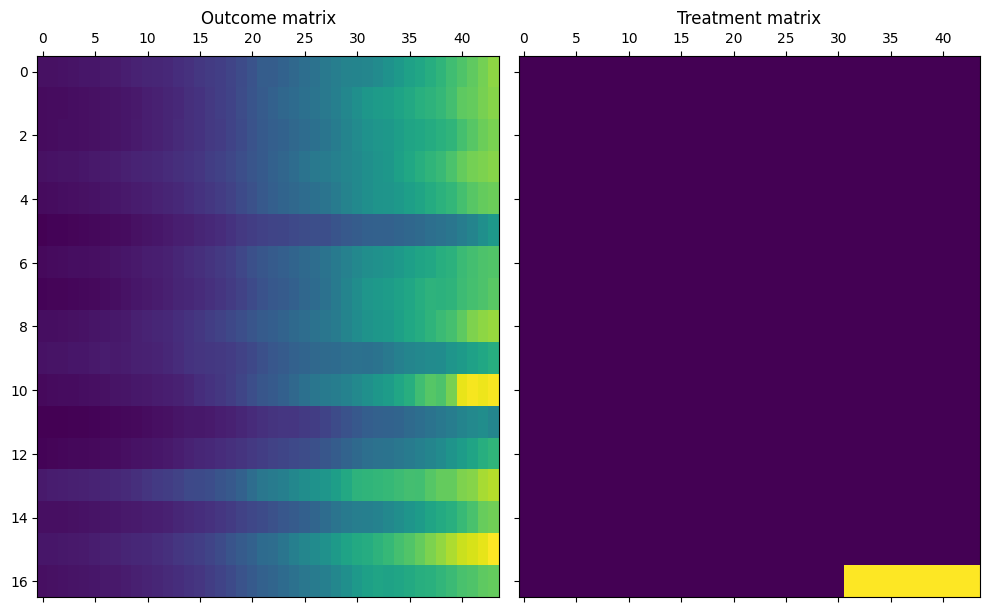

In [22]:
f, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax[0].matshow(data["Y"], aspect="auto", cmap="viridis")
ax[1].matshow(data["W"], aspect="auto", cmap="viridis")
f.tight_layout()
ax[0].set_title("Outcome matrix")
ax[1].set_title("Treatment matrix")

In [23]:
# Fit synthetic control - basic
synth = Synth(method="simplex")
results = synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True
)

You have 17 units, so the lowest possible p-value is 0.0625, which is smaller than traditional α of 0.05 
Permutation test may be unreliable


Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

In [24]:
# Fit synthetic control
mc_synth = Synth(method="matrix_completion")
mc_results = mc_synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
    verbose=True
)

shrink_treshhold: 3675.0
singular values: [51452.35453227 11822.70436841  7508.85824555  4654.04371324]
s_thresholded: [47777.35453227  8147.70436841  3833.85824555   979.04371324]
Iteration   1, relative change = 39838314219918.429688
singular values: [50711.74231427 11684.39366224  7504.91004357  4653.07251936]
s_thresholded: [47036.74231427  8009.39366224  3829.91004357   978.07251936]
Iteration   2, relative change = 0.004225
singular values: [49983.38455262 11549.76020404  7499.7451488   4652.06406673]
s_thresholded: [46308.38455262  7874.76020404  3824.7451488    977.06406673]
Iteration   3, relative change = 0.004175
singular values: [49266.62644682 11418.9620408   7493.26654718  4651.02392171]
s_thresholded: [45591.62644682  7743.9620408   3818.26654718   976.02392171]
Iteration   4, relative change = 0.004126
singular values: [48560.86471488 11292.14101835  7485.37415997  4649.95763688]
s_thresholded: [44885.86471488  7617.14101835  3810.37415997   974.95763688]
Iteration   5,

Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

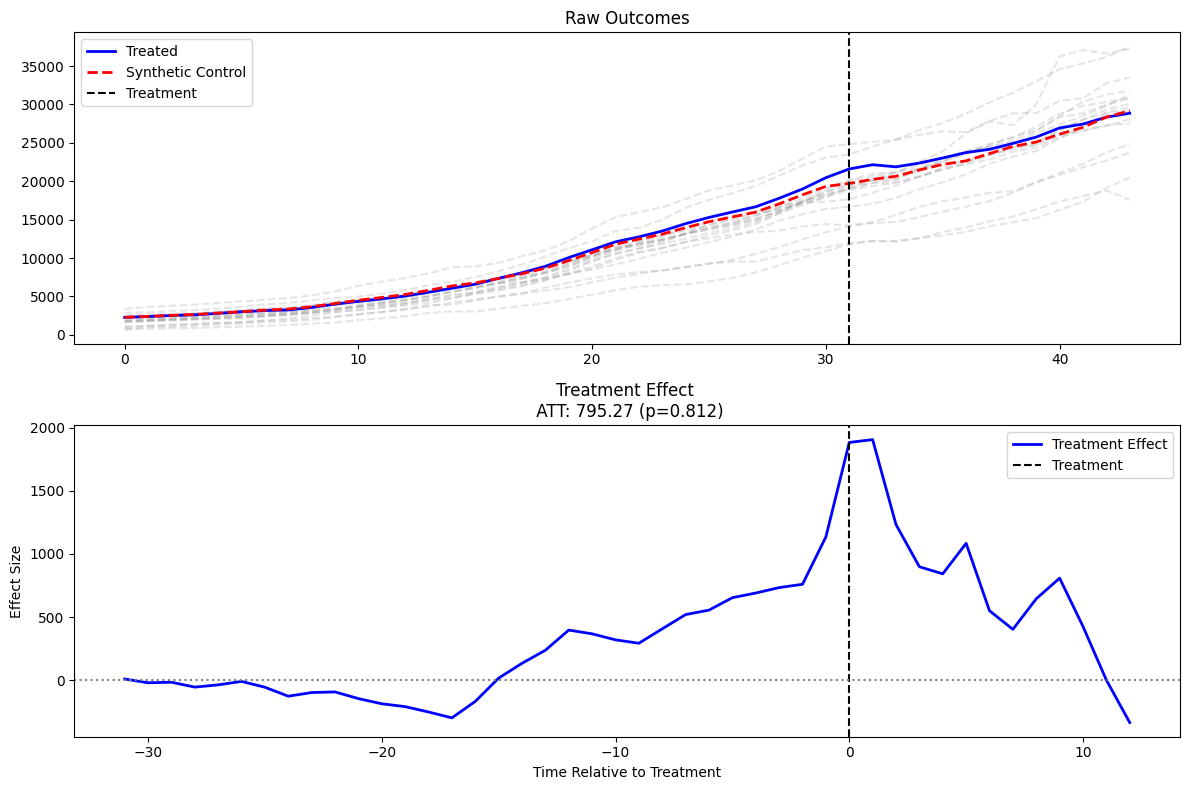

In [25]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
synth.plot(mc_results, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
synth.plot(
    mc_results,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

In [26]:
# Fit multiple synthetic controls
synth_methods = [
    Synth(method="lp_norm", p=1.0),
    Synth(method="lp_norm", p=2.0),
    Synth(method="linear"),
    Synth(method="simplex"),
    Synth(method="matrix_completion"),
    Synth(method="matrix_completion",unit_intercept=True,time_intercept=True),
]

results = [
    method.fit(data["Y"], data["treated_units"], data["T_pre"], compute_jackknife=False,verbose=False)
    for method in synth_methods
]

In [27]:
from synthlearners.plotting import SynthPlotter

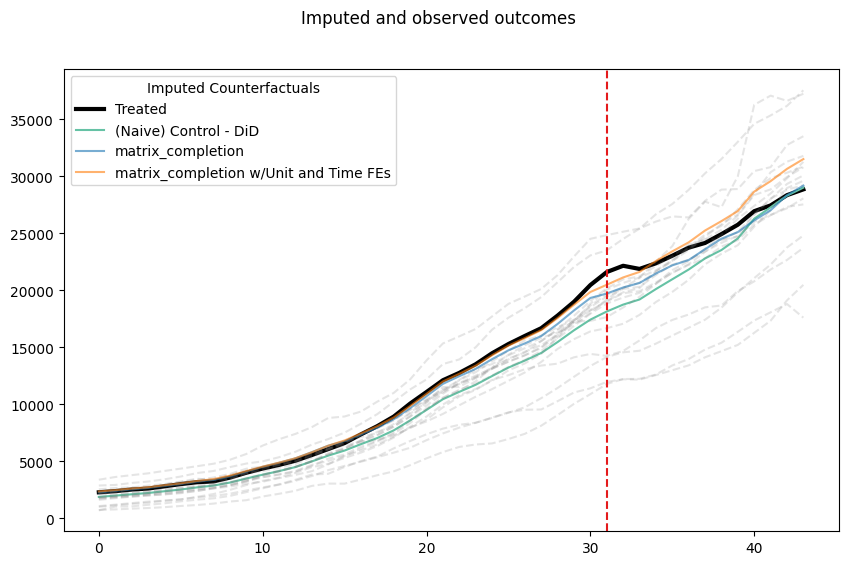

In [28]:
# Create plot
plotter = SynthPlotter()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter.plot_trajectories(
    results, data["Y"], data["treated_units"], data["T_pre"],
    ax=ax, show_controls=True
)
fig.suptitle("Imputed and observed outcomes")
plt.show()